In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from IPython.display import clear_output
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import random
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

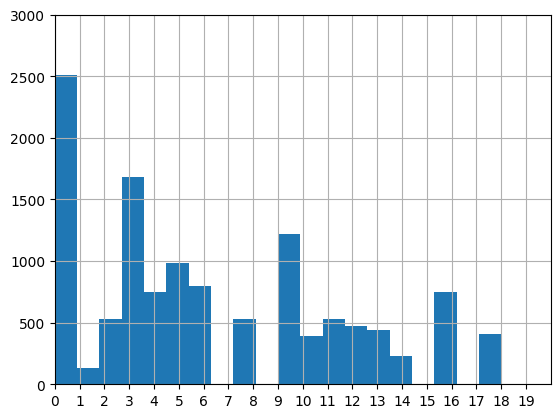

In [3]:
train_ans = pd.read_csv('human_poses_data/train_answers.csv')
vals = list(train_ans['target_feature'].values)

# plt.figure(figsize=(10, 3))
plt.axis((0, 20, 0, 3000))
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)
plt.hist(train_ans['target_feature'].values, bins=20)
plt.show()

In [4]:
targets = list(map(int, train_ans['target_feature'].values))

index_to_target = []
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')
    index_to_target.append(target)


print()
print(index_to_target)

0 - 2512
1 - 135
2 - 530
3 - 1680
4 - 752
5 - 982
6 - 800
8 - 533
9 - 1223
10 - 390
11 - 528
12 - 469
13 - 442
14 - 228
16 - 753
18 - 410

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]


In [5]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            self.label_map = label_map

            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image
# from data.data import Data

In [10]:
transform = Compose([
    Resize((150, 150)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)


train_indices, valid_indices = train_test_split(
    range(len(train_data)),
    test_size=0.15,
    stratify=targets,
    random_state=42
)

# Создаем Subset'ы
train_set = Subset(train_data, train_indices)
valid_set = Subset(train_data, valid_indices)


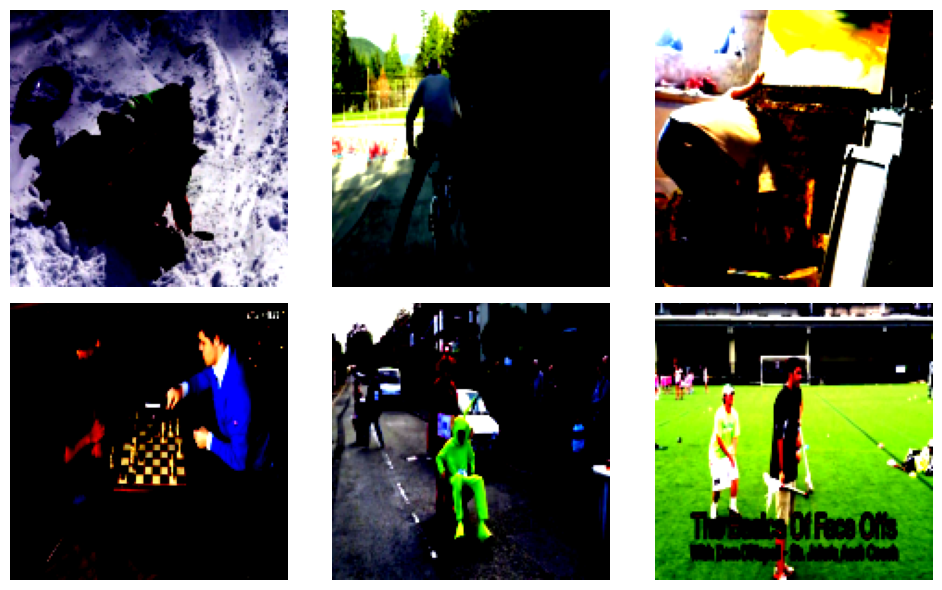

In [11]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_set, num_images=6)


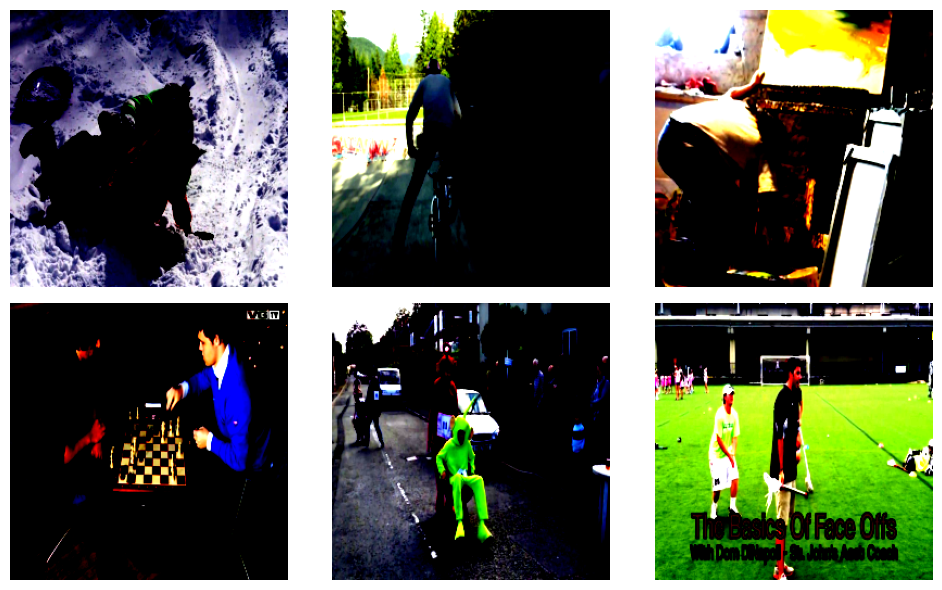

In [7]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_set, num_images=6)


In [8]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count <= 300:
                needed = current_count * 6

            elif current_count <= 400:
                needed = current_count * 3

            elif current_count <= 500:
                needed = current_count * 2

            elif current_count <= 1000:
                needed = current_count

            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = np.random.choice(self.augmentations, size=num_augs, replace=False).tolist()
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)


In [9]:
len(balanced_train_set)

21898

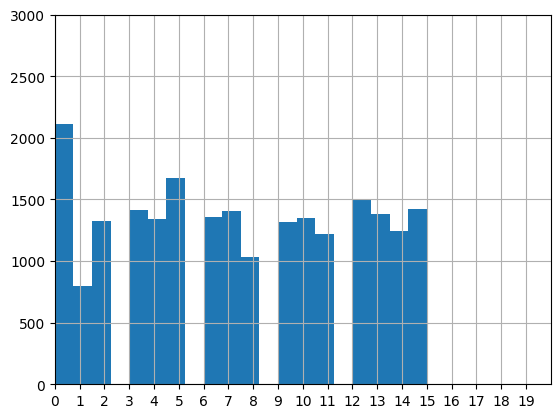

In [10]:
plt.axis((0, 20, 0, 3000))
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)

targets = []
for _, target in balanced_train_set:
    targets.append(target)

plt.hist(targets, bins=20)
plt.show()

In [11]:
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')


0 - 2113
1 - 798
2 - 1329
3 - 1416
4 - 1338
5 - 1674
6 - 1358
7 - 1404
8 - 1037
9 - 1316
10 - 1347
11 - 1218
12 - 1496
13 - 1386
14 - 1248
15 - 1420


In [12]:
# labels = [0, 0, 0, 1, 1, ...]  # Список всех меток
class_weights = compute_class_weight(
    "balanced", 
    classes=np.unique(targets), 
    y=targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [13]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(64),nn.ReLU(inplace=True))
           
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True),
                                  conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True),
                                  conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True),
                                   conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        self.apply(self.init_weights)

    def init_weights(self,m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return out

In [20]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [21]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())

            
    avg_loss = total_loss / len(dataloader)
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1
    else:
        return avg_loss, None, None


In [ ]:
class Model7(nn.Module):
    def __init__(self):
        super(Model7, self).__init__()

        # (3, 256, 256)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=0),  # (8, 254, 254)
            nn.BatchNorm2d(8),
            nn.PReLU(),
            
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0),  # (8, 252, 252)
            nn.BatchNorm2d(8),
            nn.PReLU(),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),  # (16, 250, 250)
            nn.BatchNorm2d(16),
            nn.PReLU(),
            
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),  # (16, 248, 248)
            nn.BatchNorm2d(16),
            nn.PReLU(),

            nn.MaxPool2d(kernel_size=2),  # (16, 124, 124)
        )

        # (16, 124, 124)

        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=0),  # (64, 122, 122)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),  # (64, 120, 120)
            nn.BatchNorm2d(64),
            nn.PReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),  # (128, 118, 118)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),  # (128, 116, 116)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            
            nn.MaxPool2d(kernel_size=2),  # (128, 58, 58)
        )
        # --------------skip1--------------

        # (128, 58, 58)

        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),  # (256, 56, 56)
            nn.BatchNorm2d(256),
            nn.PReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),  # (256, 54, 54)
            nn.BatchNorm2d(256),
            nn.PReLU(),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=0),  # (384, 52, 52)
            nn.BatchNorm2d(384),
            nn.PReLU(),
            
            nn.MaxPool2d(kernel_size=2),  # (384, 26, 26)
        )
        # --------------skip2--------------

        # (384, 26, 26)

        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=0),  # (384, 24, 24)
            nn.BatchNorm2d(384),
            nn.PReLU(),
            
            nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=0),  # (512, 22, 22)
            nn.BatchNorm2d(512),
            nn.PReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),  # (512, 20, 20)
            nn.BatchNorm2d(512),
            nn.PReLU(),
            
            nn.MaxPool2d(kernel_size=2),  # (512, 10, 10)
        )
        # --------------skip3--------------
        
        # (512, 10, 10)

        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),  # (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.PReLU(),
            
            nn.Conv2d(512, 640, kernel_size=3, stride=1, padding=0),  # (640, 6, 6)
            nn.BatchNorm2d(640),
            nn.PReLU(),

            nn.Conv2d(640, 640, kernel_size=3, stride=1, padding=0),  # (640, 4, 4)
            nn.BatchNorm2d(640),
            nn.PReLU(),

            nn.Conv2d(640, 768, kernel_size=3, stride=1, padding=0),  # (768, 2, 2)
            nn.BatchNorm2d(768),
            nn.PReLU(),
            
            nn.AdaptiveAvgPool2d((1, 1)),  # (768, 1, 1)
        )



        self.skip1 = nn.Sequential(  # (64, 124, 124)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 62, 62)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((58, 58))  # (128, 58, 58)
        )  

        self.skip2 = nn.Sequential(  # (128, 58, 58)
            nn.Conv2d(128, 384, kernel_size=3, stride=2, padding=1),  # (384, 29, 29)
            nn.BatchNorm2d(384),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((26, 26)),
        )  # (384, 26, 26)
        
        self.skip3 = nn.Sequential(  # (384, 26, 26)
            nn.Conv2d(384, 512, kernel_size=3, stride=2, padding=1),  # (512, 13, 13) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((10, 10)),  # (512, 10, 10)
        )  # (512, 10, 10)

        self.skip4 = nn.Sequential(  # (512, 10, 10)
            nn.Conv2d(512, 768, kernel_size=3, stride=2, padding=1),  # (768, 5, 5) 
            nn.BatchNorm2d(768),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # (768, 1, 1)
        )  # (768, 1, 1)



        self.classifier = nn.Sequential( # (768, 1, 1)
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 16)
        )

    def forward(self, x):

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [ ]:
model = Model7().to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 258, 258]           9,472
       BatchNorm2d-2         [-1, 64, 258, 258]             128
              ReLU-3         [-1, 64, 258, 258]               0
            Conv2d-4         [-1, 64, 258, 258]          36,928
       BatchNorm2d-5         [-1, 64, 258, 258]             128
              ReLU-6         [-1, 64, 258, 258]               0
            Conv2d-7         [-1, 64, 258, 258]          36,928
       BatchNorm2d-8         [-1, 64, 258, 258]             128
            Conv2d-9         [-1, 64, 258, 258]          36,928
      BatchNorm2d-10         [-1, 64, 258, 258]             128
             ReLU-11         [-1, 64, 258, 258]               0
           Conv2d-12         [-1, 64, 258, 258]          36,928
      BatchNorm2d-13         [-1, 64, 258, 258]             128
           Conv2d-14         [-1, 64, 2

In [ ]:
NUM_EPOCHS = 30

#  Обучение модели
model = Model7(in_channels=3, num_classes=16).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)

    scheduler.step(f1_)
    
    if f1[-1] == max(f1):
        torch.save(model, 'resnet_best_model.pth')
        torch.save(model.state_dict(), 'resnet_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")



print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

  0%|          | 0/172 [00:09<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.56 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.49 GiB is allocated by PyTorch, and 55.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [19]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [20]:
# model = torch.load('model4_16_best_model.pth', weights_only=False)
# model

In [21]:
# from sklearn.metrics import classification_report

# y_true, y_pred = predict(model, valid_loader)

# print(classification_report(y_true, y_pred))

In [22]:
# import torch
# torch.cuda.empty_cache()  

In [24]:
class Model8(nn.Module):
    def __init__(self):
        super(Model8, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  # (8, 256, 256)
            nn.BatchNorm2d(8),
            nn.PReLU(),

            nn.Conv2d(8, 12, kernel_size=3, stride=1, padding=1),  # (12, 256, 256)
            nn.BatchNorm2d(12),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (12, 128, 128)

            nn.Conv2d(12, 16, kernel_size=3, stride=1, padding=1),  # (16, 128, 128)
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (16, 64, 64)
        )

        # (16, 64, 64)

        # --------------BigSkip--------------
        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
            nn.BatchNorm2d(16),
            nn.PReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(), # (32, 32, 32)
        )
        # --------------skip1--------------

        # (32, 32, 32)

        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 16, 16)

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.PReLU(),
        
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),
        )
        # --------------skip2--------------

        # (32, 32, 32)

        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),

            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.PReLU(),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
            nn.BatchNorm2d(16),
            nn.PReLU(),
        )
        # --------------skip3--------------
        # --------------BigSkip--------------

        # (16, 64, 64)

        self.block5 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 16, 16)

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 4, 4)

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 2, 2)
            nn.BatchNorm2d(128),
            nn.PReLU(),
        )
        
        # (128, 2, 2)

        self.skip1 = nn.Sequential(  # (16, 64, 64)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 32)
        )

        self.skip2 = nn.Sequential(  # (32, 32, 32)
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),
        )
        
        self.skip3 = nn.Sequential(  # (32, 32, 32)
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # (16, 64, 64)
            nn.BatchNorm2d(16),
            nn.PReLU(),  # (16, 64, 64)
        )

        self.bigskip = nn.Sequential(  # (16, 64, 64)
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
            nn.BatchNorm2d(16),
            nn.PReLU(),
        )  # (16, 64, 64)



        self.classifier = nn.Sequential( # (128, 2, 2)
            nn.Linear(128 * 2 * 2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        bigskip = self.bigskip(x)

        skip = self.skip1(x)
        out = self.block2(x)
        x = skip + out

        out = self.block3(x)
        skip = self.skip2(x)
        x = skip + out

        out = self.block4(x)
        skip = self.skip3(x)
        x = skip + out + bigskip
        
        x = self.block5(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [25]:
model = Model8().to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
       BatchNorm2d-2          [-1, 8, 256, 256]              16
             PReLU-3          [-1, 8, 256, 256]               1
            Conv2d-4         [-1, 12, 256, 256]             876
       BatchNorm2d-5         [-1, 12, 256, 256]              24
             PReLU-6         [-1, 12, 256, 256]               1
         MaxPool2d-7         [-1, 12, 128, 128]               0
            Conv2d-8         [-1, 16, 128, 128]           1,744
       BatchNorm2d-9         [-1, 16, 128, 128]              32
            PReLU-10         [-1, 16, 128, 128]               1
        MaxPool2d-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 16, 64, 64]           2,320
      BatchNorm2d-13           [-1, 16, 64, 64]              32
            PReLU-14           [-1, 16,

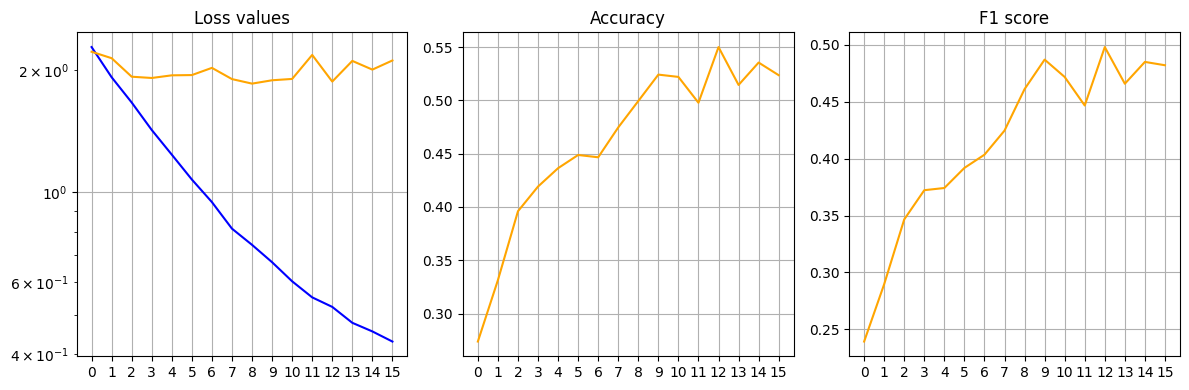

Current LR: 0.001


  3%|▎         | 5/169 [00:22<12:30,  4.58s/it]


KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 30

#  Обучение модели
model = Model8().to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.01,
                           weight_decay=1e-5
                           )
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)
    
    scheduler.step(f1_)

    if f1[-1] == max(f1):
        torch.save(model, 'model8_best_model.pth')
        torch.save(model.state_dict(), 'model8_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")



print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [27]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       399
           1       0.11      0.19      0.14        21
           2       0.38      0.24      0.29        87
           3       0.46      0.51      0.49       264
           4       0.39      0.67      0.49        83
           5       0.55      0.57      0.56       145
           6       0.61      0.59      0.60       121
           7       0.51      0.54      0.53        65
           8       0.74      0.60      0.66       186
           9       0.51      0.36      0.42        61
          10       0.43      0.67      0.52        79
          11       0.70      0.60      0.65        63
          12       0.26      0.32      0.29        68
          13       0.44      0.27      0.33        30
          14       0.51      0.56      0.54       129
          15       0.61      0.65      0.63        55

    accuracy                           0.53      1856
   macro avg       0.49   

In [28]:
model = torch.load('model8_best_model.pth', weights_only=False)

In [75]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 15/15 [00:32<00:00,  2.18s/it]

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       399
           1       0.20      0.14      0.17        21
           2       0.57      0.32      0.41        87
           3       0.55      0.42      0.48       264
           4       0.62      0.76      0.68        83
           5       0.58      0.61      0.59       145
           6       0.73      0.52      0.61       121
           7       0.50      0.66      0.57        65
           8       0.85      0.63      0.73       186
           9       0.43      0.54      0.48        61
          10       0.70      0.68      0.69        79
          11       0.51      0.86      0.64        63
          12       0.33      0.35      0.34        68
          13       0.33      0.40      0.36        30
          14       0.46      0.75      0.57       129
          15       0.86      0.69      0.77        55

    accuracy                           0.59      1856
   macro avg       0.56   

In [29]:
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for img_name in tqdm(test_set.image_files):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image)
        
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])
        test_preds.append(pred.item())

test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, [index_to_target[p] for p in test_preds]))


100%|██████████| 5301/5301 [02:00<00:00, 43.97it/s]
